## OCNS 2019, Simulating dendrites at different levels of abstraction
## KA exercise 2

### In this exercise we will see how an A-type potassium current can be used to gate backpropagating action potentials. You will start with the same setup as the previous exercises, with a three-compartment neuron model -- a soma and two dendritic compartments.

In [1]:
from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
fs = 14  # font size for plots

#Simulation parameters
h.tstop = 150  #ms
h.dt = 0.1  #ms
h.steps_per_ms = 10  #For plotting-should be compatible with dt
h.v_init = -65

### Define the morphology and active conductances

In [2]:
#------------------------------------------------------
#========== Create a soma and two dendrites and connect them.
soma=h.Section(name='soma')
dend0, dend1 = [h.Section(name=n) for n in ['dend0', 'dend1']]

# Define properties of soma
soma.diam = 20	 # um
soma.L = 200     # um
soma.Ra = 100    # Axial resistance in Ohm * cm
soma.cm = 1      # specific membrane capacitance, capacitance per unit of membrane, uF/cm^2   
soma.nseg=1

soma.insert('hh')
for seg in soma: 
    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
    seg.hh.gl = 0.0003    # Leak conductance in S/cm2
    seg.hh.el = -65       # Reversal potential in mV

# Define properties of dend0
dend0.diam = 5
dend0.L = 500
dend0.nseg=11
dend0.cm = 1
dend0.Ra = 100

dend0.insert('pas')      #Insert passive (leak) channels
for seg in dend0:
    seg.pas.e= -65
    seg.pas.g= 0.0003

# Define properties of dend1
dend1.diam = 3
dend1.L = 200
dend1.nseg=13
dend1.cm = 1
dend1.Ra = 100

dend1.insert('pas')      #Insert passive (leak) channels
for seg in dend1:
    seg.pas.e= -65
    seg.pas.g= 0.0003
    
# connect the compartments together
dend0.connect(soma(0),0)        #Connect the 0 point of dendrite 0 to the zero point of the soma
dend1.connect(dend0(1),0)  

### Add the A-type potassium current

In [3]:
soma.insert('ka')
for seg in soma:
    seg.ka.gbar = 0.0
    seg.ek = -90.
    
dend0.insert('ka')
for seg in dend0:
    seg.ka.gbar = 0.0
    seg.ek = -90.
    
dend1.insert('ka')
for seg in dend1:
    seg.ka.gbar = 0.1
    seg.ek = -90.

### We will first illustrate the effect of KA by clamping the voltage of the dendrite and observing the effect of an action potential at the soma

### First set up the stimulation:

In [4]:
#------------------------------------------------------
#========== Synaptic stimulation.
Syn_soma=h.ExpSyn(soma(0.5))
Syn_soma.e=0                     #Reverse potential of the synapse (mV)
SEC_dend = h.SEClamp(dend1(0.5))
SEC_dend.amp2 = -40.
SEC_dend.dur1 = 0
SEC_dend.dur2 = 79
SEC_dend.dur3 = 0

#========== ...create an artificial spike (an "event" to be delivered to the synapse)...
ns_soma=h.NetStim(0.5)
ns_soma.start = 80 
ns_soma.number = 1 

#... and connect the event to the synapse.
nc_soma = h.NetCon(ns_soma,Syn_soma, -10, 0, 0.4*3)

#Calculate and print in terminal the depolarization at the soma and at the middle part of the distal dendrite (dendrite[1])
vsoma_vec = h.Vector()        # Membrane potential vector
vdend1_vec = h.Vector()        # Membrane potential vector
ikadend1_vec = h.Vector()
t_vec = h.Vector()        # Time stamp vector
vsoma_vec.record(soma(0.5)._ref_v)
vdend1_vec.record(dend1(0.5)._ref_v)
ikadend1_vec.record(dend1(0.5)._ref_ik)
t_vec.record(h._ref_t)

1.0

### Run the experiment and plot the results

('Distal Dendritic depolarization w/ v-clamp:', 44.88, 'mV')
('Distal Dendritic depolarization w/out v-clamp: ', 34.0, 'mV')


/Users/wfpodlaski/anaconda/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


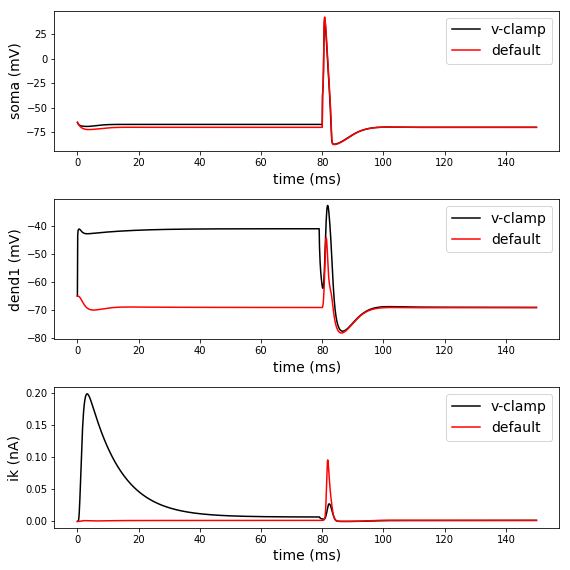

In [5]:

h.run()

plt.figure(figsize=(8,8)) # Default figsize is (8,6)
plt.subplot(3,1,1)
plt.plot(t_vec, vsoma_vec, color='black')
plt.subplot(3,1,2)
plt.plot(t_vec, vdend1_vec, color='black')
plt.subplot(3,1,3)
plt.plot(t_vec, ikadend1_vec, color='black')

print ('Distal Dendritic depolarization w/ v-clamp:', round(vdend1_vec.max()-vdend1_vec.min(),2), 'mV')

# Now compare with the default case without any dendritic depolarization
SEC_dend.dur2 = 0
h.run()

print ('Distal Dendritic depolarization w/out v-clamp: ', round(vdend1_vec.max()-vdend1_vec.min(),2), 'mV')

plt.subplot(3,1,1)
plt.plot(t_vec, vsoma_vec, color='red')
plt.legend(('v-clamp','default'),fontsize=fs)
plt.xlabel('time (ms)',fontsize=fs)
plt.ylabel('soma (mV)',fontsize=fs)
plt.subplot(3,1,2)
plt.plot(t_vec, vdend1_vec, color='red')
plt.legend(('v-clamp','default'),fontsize=fs)
plt.xlabel('time (ms)',fontsize=fs)
plt.ylabel('dend1 (mV)',fontsize=fs)
plt.subplot(3,1,3)
p=plt.plot(t_vec, ikadend1_vec, color='red')
plt.legend(('v-clamp','default'),fontsize=fs)
plt.xlabel('time (ms)',fontsize=fs)
plt.ylabel('ik (nA)',fontsize=fs)
plt.tight_layout()

# this will be used in the next part
no_clamp_voltage = round(vdend1_vec.max())

### Task 1: now let's run over different v-clamp levels to see how this affects the depolarization

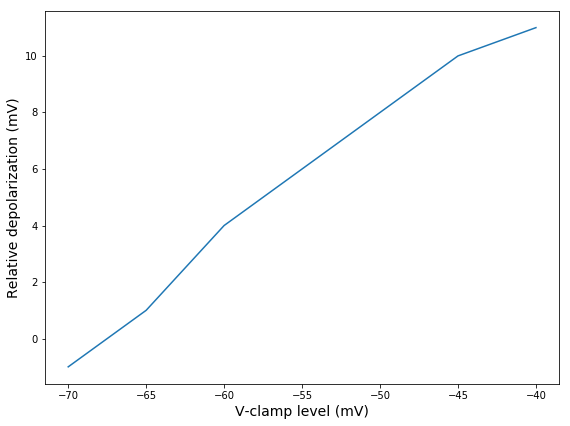

In [6]:
# loop over different voltage clamp levels to see how it affects the result

# the voltage-clamp shuts off just before somatic input is given
SEC_dend.dur2 = 79

# loop over v-clamps from -70 to -40 and record the maximum depolarization at the dendrite
clamp_levels = np.linspace(-70,-40,7)
clamp_voltages = np.zeros((len(clamp_levels),))
for i in range(len(clamp_levels)):
    SEC_dend.amp2 = clamp_levels[i]
    h.run()
    clamp_voltages[i] = round(vdend1_vec.max())
    
plt.figure(figsize=(8,6))
p=plt.plot(clamp_levels,clamp_voltages-no_clamp_voltage)
plt.xlabel('V-clamp level (mV)',fontsize=fs)
plt.ylabel('Relative depolarization (mV)',fontsize=fs)
plt.tight_layout()

In [7]:
### Task 2 -- now let's simulate the same thing, but with synaptic input

('Distal Dendritic depolarization w/ v-clamp:', 35.04, 'mV')
('Distal Dendritic depolarization w/out v-clamp: ', 34.0, 'mV')


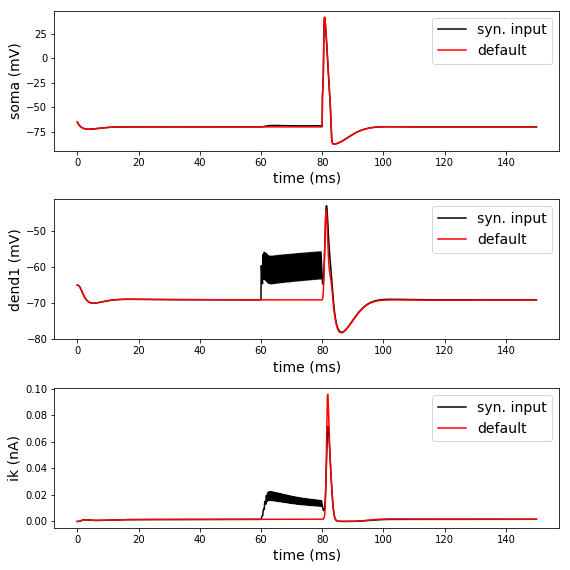

In [8]:

# first make sure the voltage-clamp is inactive
SEC_dend.dur2 = 0

# now define a synapse at the distal dendrite
Syn_dend=h.ExpSyn(dend1(0.5))
Syn_dend.e=0
ns_dend=h.NetStim(0.5)
ns_dend.start = 60      
ns_dend.number = 40
ns_dend.interval = 0.5
nc_dend = h.NetCon(ns_dend,Syn_dend, -10, 0, 0.025) 

h.run()

plt.figure(figsize=(8,8)) # Default figsize is (8,6)
plt.subplot(3,1,1)
plt.plot(t_vec, vsoma_vec, color='black')
plt.subplot(3,1,2)
plt.plot(t_vec, vdend1_vec, color='black')
plt.subplot(3,1,3)
plt.plot(t_vec, ikadend1_vec, color='black')

print ('Distal Dendritic depolarization w/ v-clamp:', round(vdend1_vec.max()-vdend1_vec.min(),2), 'mV')

# now set the weight to zero to see what happens when there is no dendritic activation
nc_dend.weight[0] = 0.0

h.run()

print ('Distal Dendritic depolarization w/out v-clamp: ', round(vdend1_vec.max()-vdend1_vec.min(),2), 'mV')

plt.subplot(3,1,1)
plt.plot(t_vec, vsoma_vec, color='red')
plt.legend(('syn. input','default'),fontsize=fs)
plt.xlabel('time (ms)',fontsize=fs)
plt.ylabel('soma (mV)',fontsize=fs)
plt.subplot(3,1,2)
plt.plot(t_vec, vdend1_vec, color='red')
plt.legend(('syn. input','default'),fontsize=fs)
plt.xlabel('time (ms)',fontsize=fs)
plt.ylabel('dend1 (mV)',fontsize=fs)
plt.subplot(3,1,3)
plt.plot(t_vec, ikadend1_vec, color='red')
plt.legend(('syn. input','default'),fontsize=fs)
plt.xlabel('time (ms)',fontsize=fs)
plt.ylabel('ik (nA)',fontsize=fs)
plt.tight_layout()
